In [1]:
!pip install google-play-scraper pandas nltk sastrawi emoji wordcloud matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 21.5 MB/s eta 0:00:00


In [2]:
from google_play_scraper import reviews, Sort
import pandas as pd

def scrape_playstore(app_id, app_name, jumlah=5000):
    hasil, _ = reviews(
        app_id,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        count=jumlah
    )

    df = pd.DataFrame(hasil)

    # Validasi kolom agar tidak error
    if 'content' not in df.columns or 'score' not in df.columns:
        print(f"⚠️ Review {app_name} tidak tersedia")
        return pd.DataFrame(columns=['content', 'score', 'app'])

    df = df[['content', 'score']]
    df['app'] = app_name
    return df

# Scraping masing-masing aplikasi
df_wattpad = scrape_playstore('wp.wattpad', 'Wattpad')
df_fizzo   = scrape_playstore('e.books.reading.apps', 'Fizzo Novel')

print("Wattpad:", df_wattpad.shape)
print("Fizzo:", df_fizzo.shape)

df_wattpad.head()


Wattpad: (5000, 3)
Fizzo: (5000, 3)


,content,score,app
0,"bagus sih, cuma ngapain tiba tiba ke shopee mu...",3,Wattpad
1,very annoying,1,Wattpad
2,banyak bugnya pas nulis katanya pas nyimpan dr...,1,Wattpad
3,fitur search nya benerin lah masa terpopuler v...,1,Wattpad
4,"ini ko Wattpad aneh bgt ya, aku mau nyari crit...",1,Wattpad


In [3]:
import re, emoji, nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
kamus_gaul = {
    "gk": "tidak",
    "ga": "tidak",
    "nggak": "tidak",
    "bgt": "banget",
    "udh": "sudah",
    "aja": "saja",
    "wkwkwk": "tertawa",
    "pdhl": "padahal",
    "please": "tolong",
    "nga": "tidak"
}

In [5]:
stop_words = set(stopwords.words('indonesian'))
stemmer = StemmerFactory().create_stemmer()

In [6]:
def preprocess(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')
    text = text.encode('ascii','ignore').decode()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    tokens = [kamus_gaul.get(k,k) for k in tokens]
    tokens = [k for k in tokens if len(k) > 3]
    tokens = [re.sub(r'(.)\1+', r'\1', k) for k in tokens]
    tokens = [k for k in tokens if k not in stop_words]
    tokens = [stemmer.stem(k) for k in tokens]

    return ' '.join(tokens)

In [7]:
# Label berdasarkan rating
def label_rating(score):
    if score <= 2:
        return 'negatif'
    elif score == 3:
        return 'netral'
    else:
        return 'positif'

# Kamus sentimen isi komentar
kamus_sentimen = {
    'positif':['bagus','keren','mantap','suka','seru'],
    'negatif':['jelek','error','lemot','kecewa','iklan','eror','gabisa','hilang','susah','kesel','ngeselin']
}

def label_kamus(text):
    for s, kata in kamus_sentimen.items():
        for k in kata:
            if k in text:
                return s
    return 'netral'


In [19]:
def label_final(row):
    # Jika rating dan kamus sama → aman
    if row['label_rating'] == row['label_kamus']:
        return row['label_rating']

    # Jika berbeda → pakai lexicon (kamus)
    return row['label_kamus']

In [20]:
def label_final(row):
    # Jika rating dan kamus sama → aman
    if row['label_rating'] == row['label_kamus']:
        return row['label_rating']

    # Jika berbeda → pakai lexicon (kamus)
    return row['label_kamus']

In [21]:
def proses_aplikasi(df):
    df = df.drop_duplicates(subset='content')
    df['clean_text'] = df['content'].astype(str).apply(preprocess)

    # LABEL DIGABUNG DALAM SATU TABEL
    df['label_rating'] = df['score'].apply(label_rating)
    df['label_kamus']  = df['clean_text'].apply(label_kamus)

    return df

df_wattpad = proses_aplikasi(df_wattpad)
df_fizzo   = proses_aplikasi(df_fizzo)

/tmp/ipython-input-1207738535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['content'].astype(str).apply(preprocess)
/tmp/ipython-input-1207738535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_rating'] = df['score'].apply(label_rating)
/tmp/ipython-input-1207738535.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

**Reasoning**:
To prevent the `SettingWithCopyWarning` when assigning new columns, I will modify the `proses_aplikasi` function to explicitly create a copy of the DataFrame after dropping duplicates.



In [22]:
def proses_aplikasi(df):
    df = df.drop_duplicates(subset='content').copy()
    df['clean_text'] = df['content'].astype(str).apply(preprocess)

    # LABEL DIGABUNG DALAM SATU TABEL
    df['label_rating'] = df['score'].apply(label_rating)
    df['label_kamus']  = df['clean_text'].apply(label_kamus)

    return df

df_wattpad = proses_aplikasi(df_wattpad)
df_fizzo   = proses_aplikasi(df_fizzo)

In [23]:
df_wattpad['label_final'] = df_wattpad.apply(label_final, axis=1)
df_fizzo['label_final']   = df_fizzo.apply(label_final, axis=1)

In [24]:
df_wattpad['label_final'] = df_wattpad.apply(label_final, axis=1)
df_fizzo['label_final']   = df_fizzo.apply(label_final, axis=1)

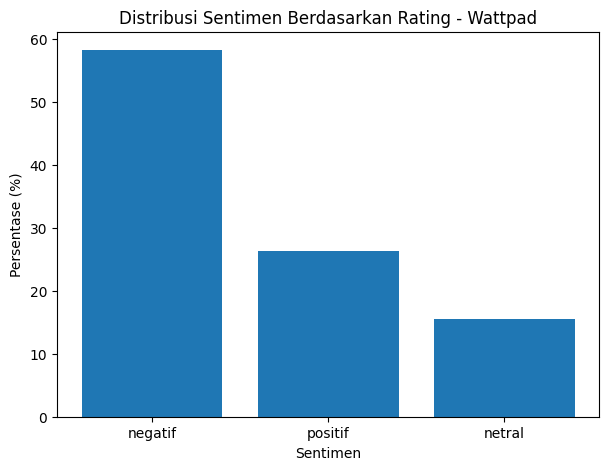

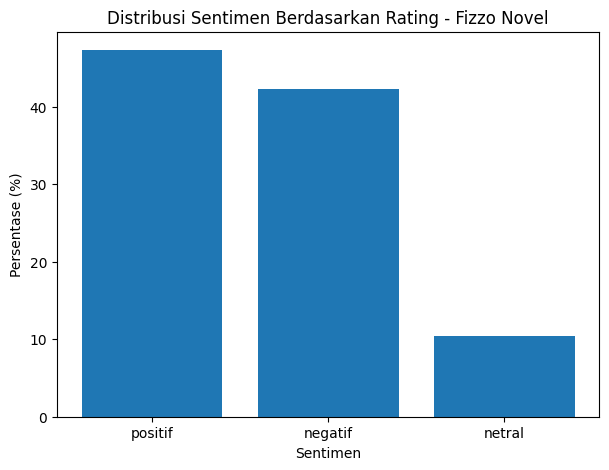

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

def visualisasi_rating(df, app_name):
    dist = df['label_rating'].value_counts(normalize=True) * 100

    plt.figure(figsize=(7,5))
    plt.bar(dist.index, dist.values)
    plt.title(f'Distribusi Sentimen Berdasarkan Rating - {app_name}')
    plt.ylabel('Persentase (%)')
    plt.xlabel('Sentimen')
    plt.xticks(rotation=0)
    plt.show()

# Wattpad
visualisasi_rating(df_wattpad, 'Wattpad')

# Fizzo Novel
visualisasi_rating(df_fizzo, 'Fizzo Novel')

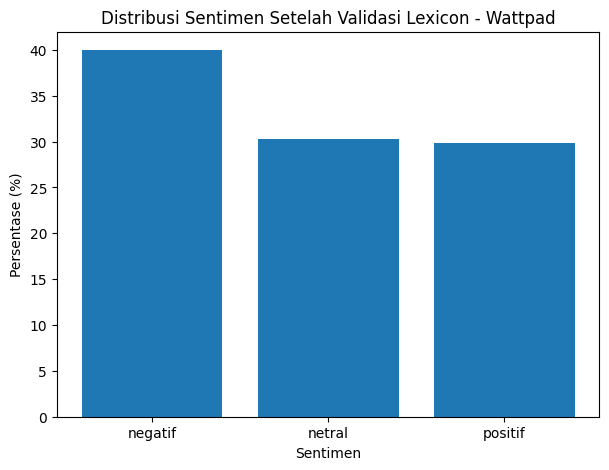

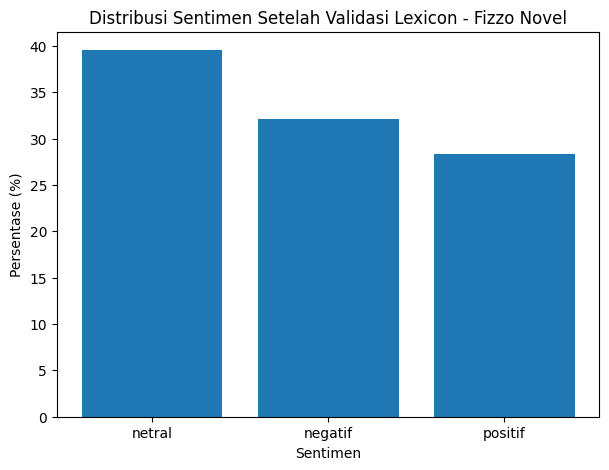

In [26]:
def visualisasi_final(df, app_name):
    dist = df['label_final'].value_counts(normalize=True) * 100

    plt.figure(figsize=(7,5))
    plt.bar(dist.index, dist.values)
    plt.title(f'Distribusi Sentimen Setelah Validasi Lexicon - {app_name}')
    plt.ylabel('Persentase (%)')
    plt.xlabel('Sentimen')
    plt.xticks(rotation=0)
    plt.show()

visualisasi_final(df_wattpad, 'Wattpad')
visualisasi_final(df_fizzo, 'Fizzo Novel')

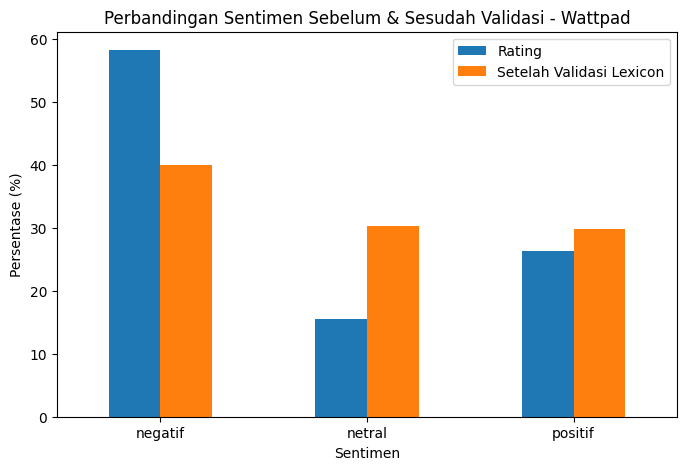

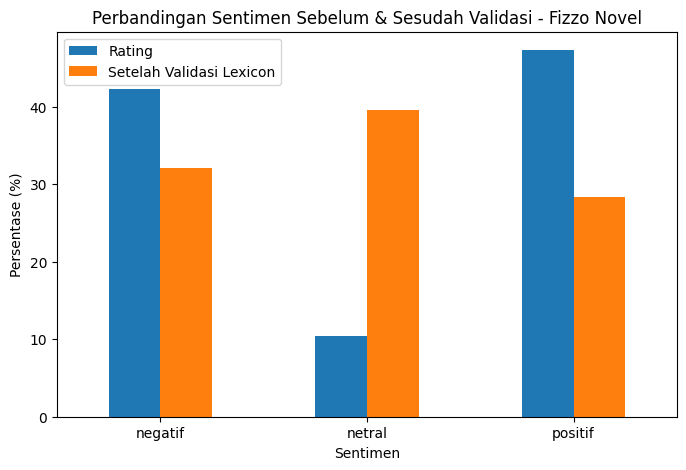

In [27]:
def bandingkan_sebelum_sesudah(df, app_name):
    data = pd.DataFrame({
        'Rating': df['label_rating'].value_counts(normalize=True) * 100,
        'Setelah Validasi Lexicon': df['label_final'].value_counts(normalize=True) * 100
    }).fillna(0)

    data.plot(kind='bar', figsize=(8,5))
    plt.title(f'Perbandingan Sentimen Sebelum & Sesudah Validasi - {app_name}')
    plt.ylabel('Persentase (%)')
    plt.xlabel('Sentimen')
    plt.xticks(rotation=0)
    plt.show()

bandingkan_sebelum_sesudah(df_wattpad, 'Wattpad')
bandingkan_sebelum_sesudah(df_fizzo, 'Fizzo Novel')

In [28]:
def tabel_sebelum(df, app_name):
    urutan = ['positif', 'netral', 'negatif']
    tabel = (df['label_rating']
             .value_counts()
             .reindex(urutan, fill_value=0)
             .reset_index())

    tabel.columns = ['Sentimen', 'Jumlah Komentar']
    print(f'\nTABEL SEBELUM VALIDASI - {app_name}')
    print(tabel)
    return tabel

tabel_wattpad_sebelum = tabel_sebelum(df_wattpad, 'Wattpad')
tabel_fizzo_sebelum   = tabel_sebelum(df_fizzo, 'Fizzo Novel')


TABEL SEBELUM VALIDASI - Wattpad
  Sentimen  Jumlah Komentar
0  positif             1281
1   netral              752
2  negatif             2828

TABEL SEBELUM VALIDASI - Fizzo Novel
  Sentimen  Jumlah Komentar
0  positif             2202
1   netral              482
2  negatif             1970


In [29]:
def tabel_sesudah(df, app_name):
    urutan = ['positif', 'netral', 'negatif']
    tabel = (df['label_final']
             .value_counts()
             .reindex(urutan, fill_value=0)
             .reset_index())

    tabel.columns = ['Sentimen', 'Jumlah Komentar']
    print(f'\nTABEL SESUDAH VALIDASI - {app_name}')
    print(tabel)
    return tabel

tabel_wattpad_sesudah = tabel_sesudah(df_wattpad, 'Wattpad')
tabel_fizzo_sesudah   = tabel_sesudah(df_fizzo, 'Fizzo Novel')


TABEL SESUDAH VALIDASI - Wattpad
  Sentimen  Jumlah Komentar
0  positif             1448
1   netral             1470
2  negatif             1943

TABEL SESUDAH VALIDASI - Fizzo Novel
  Sentimen  Jumlah Komentar
0  positif             1317
1   netral             1841
2  negatif             1496


In [30]:
def tabel_perbandingan(tabel_sebelum, tabel_sesudah, app_name):
    tabel = pd.merge(
        tabel_sebelum,
        tabel_sesudah,
        on='Sentimen',
        suffixes=('_Sebelum', '_Sesudah')
    )

    print(f'\nTABEL PERBANDINGAN - {app_name}')
    print(tabel)
    return tabel

banding_wattpad = tabel_perbandingan(
    tabel_wattpad_sebelum, tabel_wattpad_sesudah, 'Wattpad'
)

banding_fizzo = tabel_perbandingan(
    tabel_fizzo_sebelum, tabel_fizzo_sesudah, 'Fizzo Novel'
)


TABEL PERBANDINGAN - Wattpad
  Sentimen  Jumlah Komentar_Sebelum  Jumlah Komentar_Sesudah
0  positif                     1281                     1448
1   netral                      752                     1470
2  negatif                     2828                     1943

TABEL PERBANDINGAN - Fizzo Novel
  Sentimen  Jumlah Komentar_Sebelum  Jumlah Komentar_Sesudah
0  positif                     2202                     1317
1   netral                      482                     1841
2  negatif                     1970                     1496


In [31]:
def persentase_sebelum(df):
    return (df['label_rating']
            .value_counts(normalize=True)
            .mul(100)
            .round(2))

print("WATTPAD - SEBELUM VALIDASI")
display(persentase_sebelum(df_wattpad))

print("FIZZO NOVEL - SEBELUM VALIDASI")
display(persentase_sebelum(df_fizzo))

WATTPAD - SEBELUM VALIDASI


,proportion
label_rating,
negatif,58.18
positif,26.35
netral,15.47


FIZZO NOVEL - SEBELUM VALIDASI


,proportion
label_rating,
positif,47.31
negatif,42.33
netral,10.36


In [32]:
def persentase_sesudah(df):
    return (df['label_final']
            .value_counts(normalize=True)
            .mul(100)
            .round(2))

print("WATTPAD - SESUDAH VALIDASI")
display(persentase_sesudah(df_wattpad))

print("FIZZO NOVEL - SESUDAH VALIDASI")
display(persentase_sesudah(df_fizzo))

WATTPAD - SESUDAH VALIDASI


,proportion
label_final,
negatif,39.97
netral,30.24
positif,29.79


FIZZO NOVEL - SESUDAH VALIDASI


,proportion
label_final,
netral,39.56
negatif,32.14
positif,28.30


In [33]:
def tabel_perbandingan(df):
    sebelum = persentase_sebelum(df)
    sesudah = persentase_sesudah(df)

    tabel = pd.DataFrame({
        'Sebelum Validasi (%)': sebelum,
        'Sesudah Validasi (%)': sesudah
    }).fillna(0)

    tabel['Perubahan (%)'] = (tabel['Sesudah Validasi (%)'] -
                              tabel['Sebelum Validasi (%)']).round(2)
    return tabel

print("PERBANDINGAN WATTPAD")
display(tabel_perbandingan(df_wattpad))

print("PERBANDINGAN FIZZO NOVEL")
display(tabel_perbandingan(df_fizzo))

PERBANDINGAN WATTPAD


,Sebelum Validasi (%),Sesudah Validasi (%),Perubahan (%)
negatif,58.18,39.97,-18.21
netral,15.47,30.24,14.77
positif,26.35,29.79,3.44


PERBANDINGAN FIZZO NOVEL


,Sebelum Validasi (%),Sesudah Validasi (%),Perubahan (%)
negatif,42.33,32.14,-10.19
netral,10.36,39.56,29.20
positif,47.31,28.30,-19.01


In [34]:
def hitung_bias(df):
    return len(df[df['label_rating'] != df['label_final']]) / len(df) * 100

print("Persentase perubahan label Wattpad:", hitung_bias(df_wattpad))
print("Persentase perubahan label Fizzo:", hitung_bias(df_fizzo))

Persentase perubahan label Wattpad: 50.23657683604197
Persentase perubahan label Fizzo: 52.04125483455092


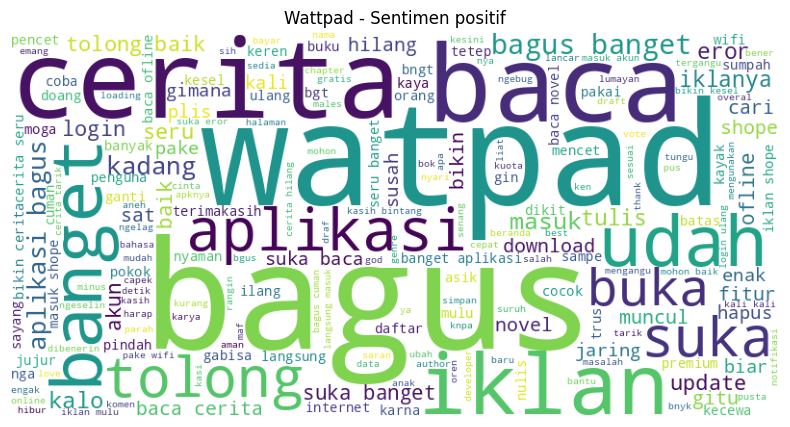

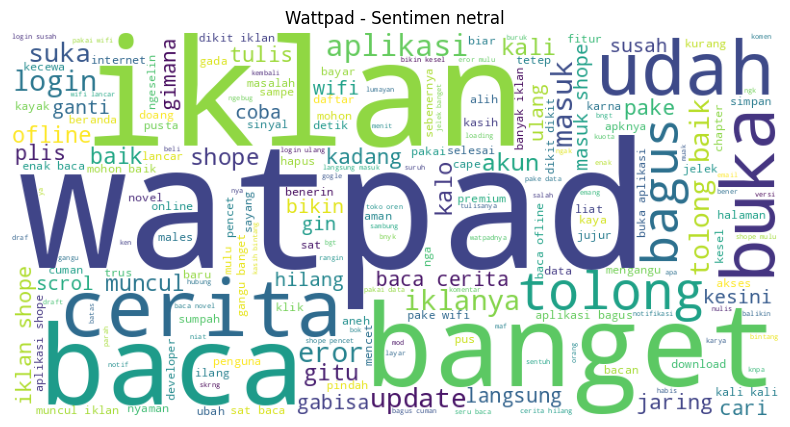

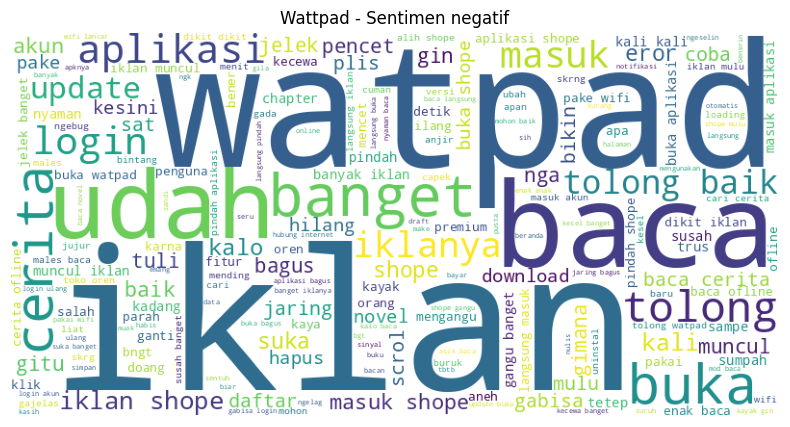

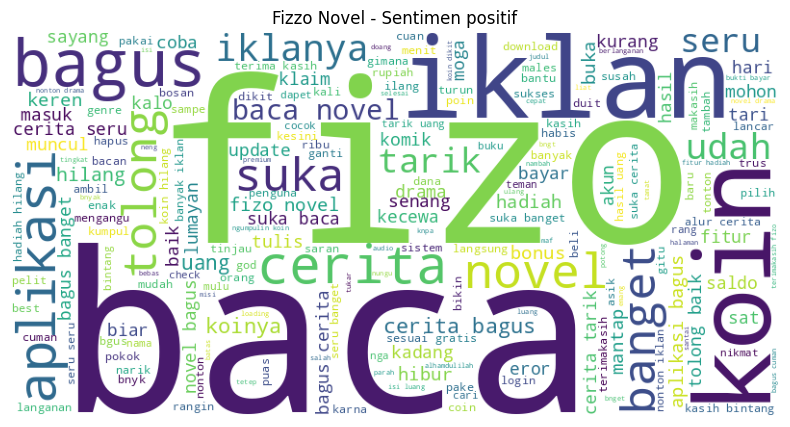

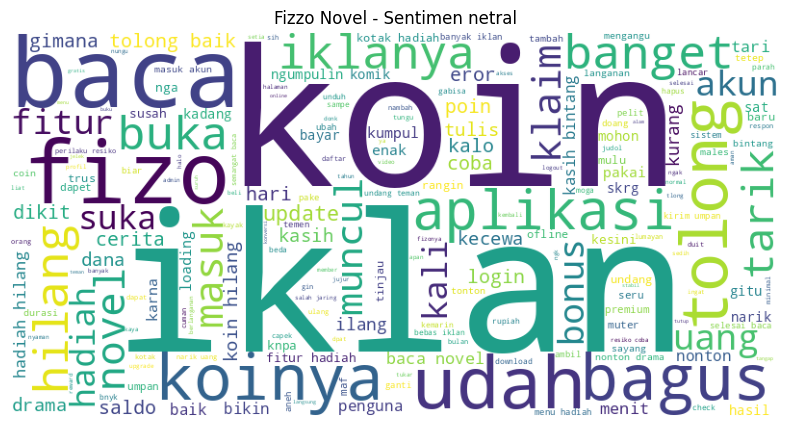

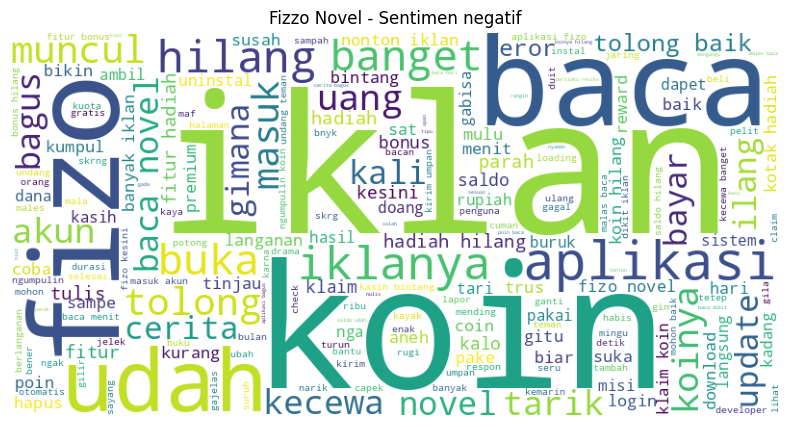

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud_app(df, app_name):
    for sentimen in ['positif','netral','negatif']:
        text = ' '.join(df[df['label_rating']==sentimen]['clean_text'])
        if text.strip() == "":
            continue

        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc)
        plt.axis('off')
        plt.title(f'{app_name} - Sentimen {sentimen}')
        plt.show()

wordcloud_app(df_wattpad, 'Wattpad')
wordcloud_app(df_fizzo, 'Fizzo Novel')

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

def fourgram_per_sentimen(df, app_name, sentimen):
    # Ambil data berdasarkan sentimen
    df_sent = df[df['label_rating'] == sentimen]

    # Jika data kosong, hentikan
    if df_sent.empty:
        print(f"Tidak ada data {sentimen} untuk {app_name}")
        return

    # CountVectorizer khusus 4-gram
    vectorizer = CountVectorizer(
        ngram_range=(4, 4),
        max_features=10
    )

    X = vectorizer.fit_transform(df_sent['clean_text'])

    frekuensi = X.sum(axis=0).A1
    kata = vectorizer.get_feature_names_out()

    df_ngram = pd.DataFrame({
        '4-gram': kata,
        'frekuensi': frekuensi
    }).sort_values(by='frekuensi')

    # Visualisasi
    plt.figure(figsize=(8,5))
    plt.barh(df_ngram['4-gram'], df_ngram['frekuensi'])
    plt.title(f'{app_name} - Sentimen {sentimen} (4-gram)')
    plt.xlabel('Frekuensi')
    plt.show()

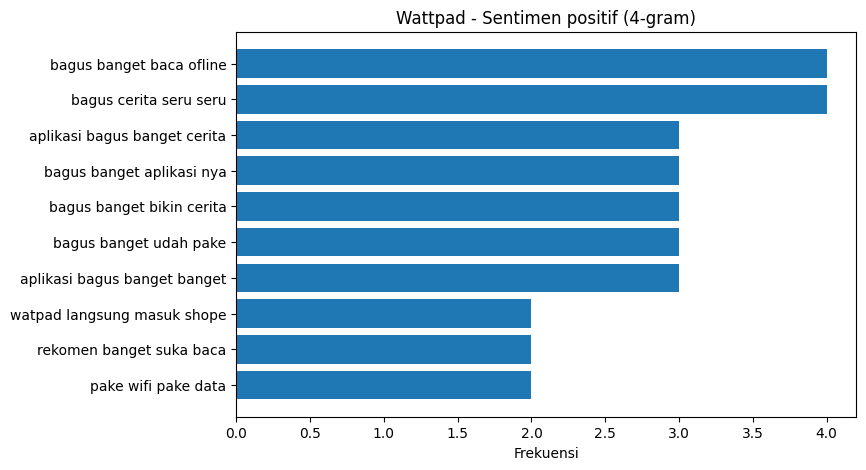

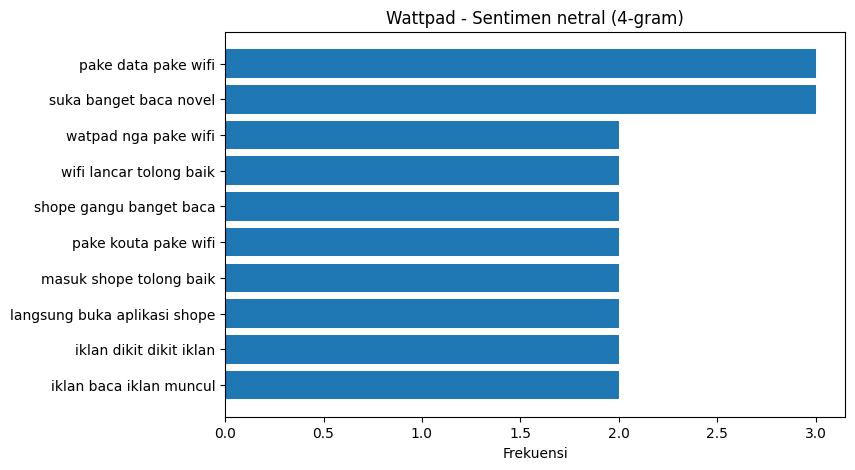

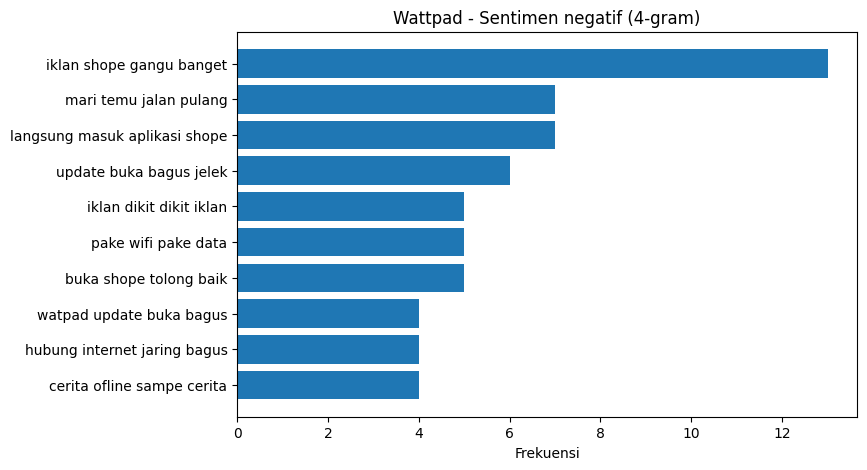

In [38]:
for sentimen in ['positif', 'netral', 'negatif']:
    fourgram_per_sentimen(df_wattpad, 'Wattpad', sentimen)

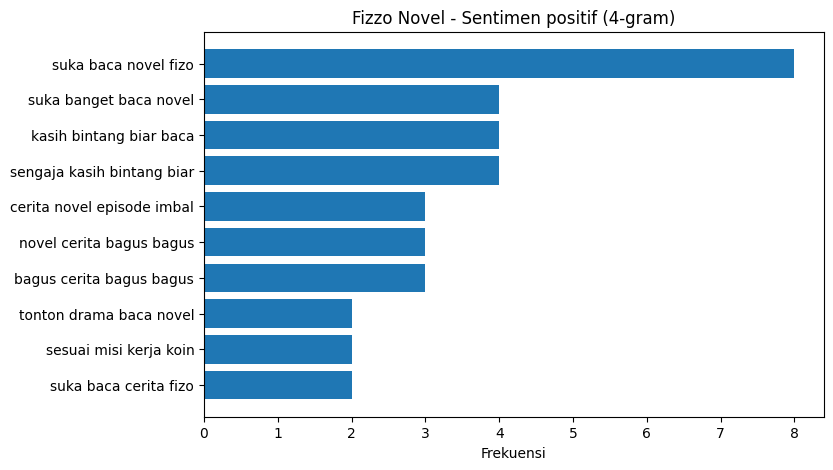

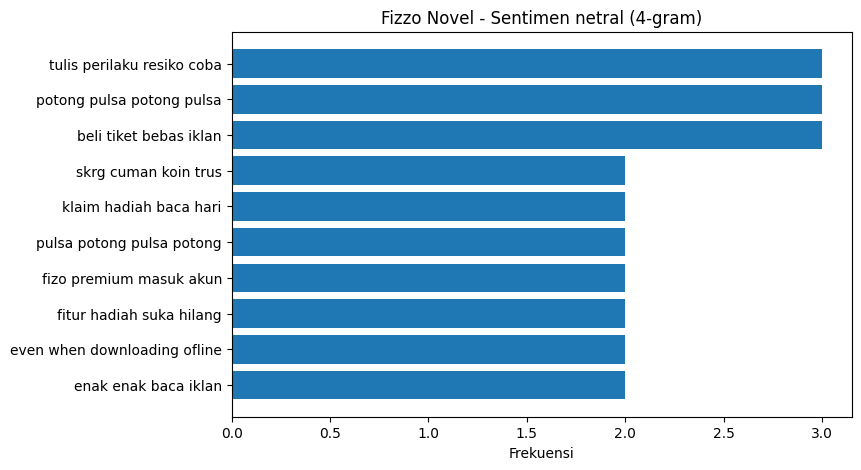

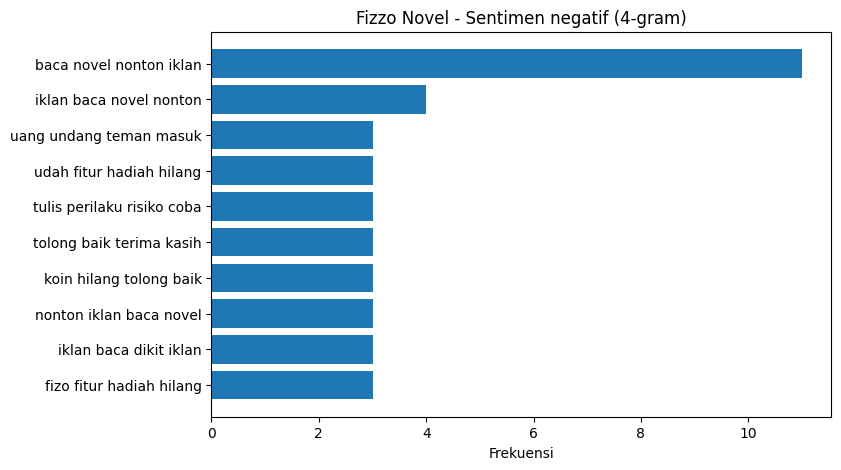

In [39]:
for sentimen in ['positif', 'netral', 'negatif']:
    fourgram_per_sentimen(df_fizzo, 'Fizzo Novel', sentimen)

In [41]:
# 1. Import library
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Misal dataset sudah memiliki kolom 'text' dan 'label_final'

# 2. Gabungkan dataset jika ingin satu model, atau pisahkan untuk masing-masing aplikasi
df_wattpad['app'] = 'wattpad'
df_fizzo['app']   = 'fizzo'
df_all = pd.concat([df_wattpad, df_fizzo], ignore_index=True)

# 3. Pisahkan fitur dan target
X = df_all['clean_text']  # Corrected from 'text' to 'clean_text'
y = df_all['label_final']

# 4. Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Transformasi teks menjadi vektor numerik (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

# 6. Pemodelan awal menggunakan Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# 7. Prediksi dan evaluasi
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi awal:", accuracy)
print("\nLaporan klasifikasi:\n", classification_report(y_test, y_pred))

# 8. Perbaikan model menggunakan GridSearch (tuning hyperparameter) atau algoritma lain
param_grid = {'alpha': [0.1, 0.5, 1.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_tfidf, y_train)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Akurasi setelah tuning:", accuracy_best)
print("\nLaporan klasifikasi setelah tuning:\n", classification_report(y_test, y_pred_best))

Akurasi awal: 0.8449816079873883

Laporan klasifikasi:
               precision    recall  f1-score   support

     negatif       0.80      0.91      0.85       709
      netral       0.84      0.79      0.82       617
     positif       0.92      0.82      0.87       577

    accuracy                           0.84      1903
   macro avg       0.85      0.84      0.84      1903
weighted avg       0.85      0.84      0.84      1903

Akurasi setelah tuning: 0.8449816079873883

Laporan klasifikasi setelah tuning:
               precision    recall  f1-score   support

     negatif       0.80      0.91      0.85       709
      netral       0.84      0.79      0.82       617
     positif       0.92      0.82      0.87       577

    accuracy                           0.84      1903
   macro avg       0.85      0.84      0.84      1903
weighted avg       0.85      0.84      0.84      1903

